In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import torch

In [2]:
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [8]:
data_path = "../data/archive/hasy-data-labels.csv"
base_path = "../data/archive/"

images = []
labels = []

df = pd.read_csv(data_path)

for i in df.index:
    img_path = os.path.join(base_path, str(df.loc[i, "path"]))

    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)

    if img is None:
        continue
    
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(grey_img)
    
    label = df.loc[i, "symbol_id"]
    labels.append(label)

images = torch.FloatTensor(np.array(images)[:, np.newaxis, :, :])
labels = torch.FloatTensor(np.array(labels))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=0)
X_train = X_train.to(dml)
X_test = X_test.to(dml)

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output = False)

labels_int = label_encoder.fit_transform(labels)
onehot_encoder.fit(np.reshape(labels_int, (len(labels), 1)))

y_train_int = torch.FloatTensor(label_encoder.transform(y_train))
y_train_onehot = torch.FloatTensor(onehot_encoder.transform(np.reshape(y_train_int, (len(y_train_int), 1))))
y_test_int = torch.FloatTensor(label_encoder.transform(y_test))
y_test_onehot = torch.FloatTensor(onehot_encoder.transform(np.reshape(y_test_int, (len(y_test_int), 1))))

y_train_int = y_train_int.to(dml)
y_test_int = y_test_int.to(dml)

num_of_classes = len(label_encoder.classes_)
input_shape = X_train[0].shape

print(num_of_classes)
print(input_shape)

np.save("classes.npy", label_encoder.classes_)

369
torch.Size([1, 32, 32])


In [11]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, in_channels, num_of_classes) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=64 * 5 * 5, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_of_classes)
        )

        # 1 * 32 * 32
        # 32 * 28 * 28
        # 32 * 14 * 14
        # 64 * 10 * 10
        # 64 * 5 * 5

        self.init_weights()

    def forward(self, x):
        return self.model(x)
    
    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [12]:
def get_accuracy(model, X, y):
    outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    total_correct = (predicted == y).sum().item()
    total_samples = y.shape[0]
    accuracy = 100 * total_correct / total_samples
    return accuracy

In [13]:
model = CNN(1, num_of_classes).to(dml)

num_epochs = 40
batch_size = 1000
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    
    model.train()

    for i in range(0, len(X_train), batch_size):
    
        X_train_batch = X_train[i:(i + batch_size)].to(dml)
        y_train_onehot_batch = y_train_onehot[i:(i + batch_size)].to(dml) 
        y_train_int_batch = y_train_int[i:(i + batch_size)]

        # forward
        outputs = model(X_train_batch)
        loss = criterion(outputs, y_train_onehot_batch)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i / batch_size) % 20 == 0:
          print(f"epoch {epoch}, mini-batch {i / batch_size}/{len(X_train) / batch_size} loss is {loss.item()}")

    model.eval()

    # test_accuracy = get_accuracy(model, X_test, y_test_int)

    outputs = model(X_test[0:1000])
    _, predicted = torch.max(outputs, 1)
    total_correct = (predicted == y_test_int[0:1000]).sum().item()
    total_samples = y_test_int[0:1000].shape[0]
    test_accuracy = 100 * total_correct / total_samples
    test_accuracies.append(test_accuracy)

    outputs = model(X_train[0:1000])
    _, predicted = torch.max(outputs, 1)
    total_correct = (predicted == y_train_int[0:1000]).sum().item()
    total_samples = y_train_int[0:1000].shape[0]
    train_accuracy = 100 * total_correct / total_samples
    train_accuracies.append(train_accuracy)

    print(f"epoch {epoch}: train_accuracy is {train_accuracy}, test_accuracy is {test_accuracy}")

epoch 0, mini-batch 0.0/117.506 loss is 118.46453857421875
epoch 0, mini-batch 20.0/117.506 loss is 5.648243427276611
epoch 0, mini-batch 40.0/117.506 loss is 5.546192646026611
epoch 0, mini-batch 60.0/117.506 loss is 5.47504997253418
epoch 0, mini-batch 80.0/117.506 loss is 5.474151611328125
epoch 0, mini-batch 100.0/117.506 loss is 5.428908348083496
epoch 0: train_accuracy is 1.6, test_accuracy is 1.4
epoch 1, mini-batch 0.0/117.506 loss is 5.417917251586914
epoch 1, mini-batch 20.0/117.506 loss is 5.286795139312744
epoch 1, mini-batch 40.0/117.506 loss is 5.089631080627441
epoch 1, mini-batch 60.0/117.506 loss is 4.760851860046387
epoch 1, mini-batch 80.0/117.506 loss is 4.392483711242676
epoch 1, mini-batch 100.0/117.506 loss is 3.9731638431549072
epoch 1: train_accuracy is 34.3, test_accuracy is 32.3
epoch 2, mini-batch 0.0/117.506 loss is 3.642746925354004
epoch 2, mini-batch 20.0/117.506 loss is 3.390794515609741
epoch 2, mini-batch 40.0/117.506 loss is 3.0495762825012207
epoch 

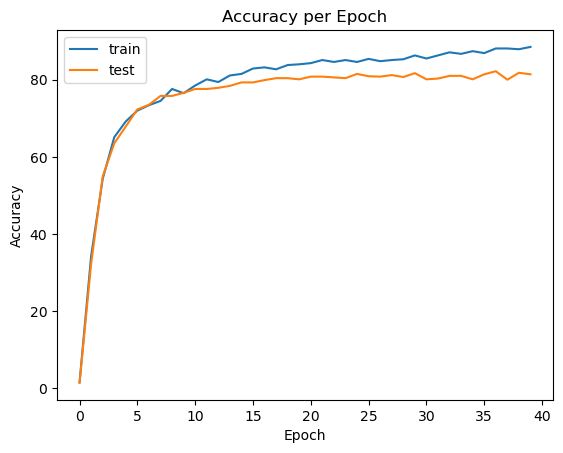

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_accuracies, label="train")
ax.plot(range(num_epochs), test_accuracies, label="test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()
plt.show()

In [15]:
out = model(X_test[76][None, :, :, :])
_, predicted = torch.max(out, 1)
print(predicted)
print(y_test_int[76])

tensor([102], device='privateuseone:0')
tensor(309., device='privateuseone:0')


In [18]:
from torch import save

model = model.to("cpu")
with open('model_state.pt', 'wb') as f: 
        save(model.state_dict(), f)

In [17]:
from torch import load

with open('model_state.pt', 'rb') as f: 
        model.load_state_dict(load(f))  